# Image Classification with CNN using Keras

# Task 1: Import Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.0.1
Is using GPU? False


# Task 2: Preprocess Data

In [11]:
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    print(indices)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)#randon the indices and unique
    print(indices)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y) # one hot encoding the labels
    
    return x, y

In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

[   29    30    35 ... 49987 49991 49995]
[ 5507  4934  3037 ...  8326 12602  3349]
[   3   10   21 ... 9970 9982 9989]
[1027 1867 1385 ...  214  440  491]
(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Task 3: Visualize Examples

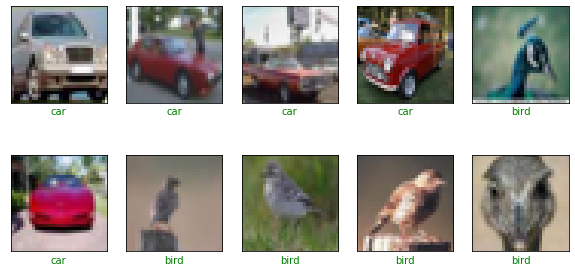

In [15]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x,y,p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices] #image
    y = y[indices] #label
    p = p[indices] #prediction
    
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5, 1 + i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color = col)
    plt.show()

show_random_examples(x_train, y_train, y_train)

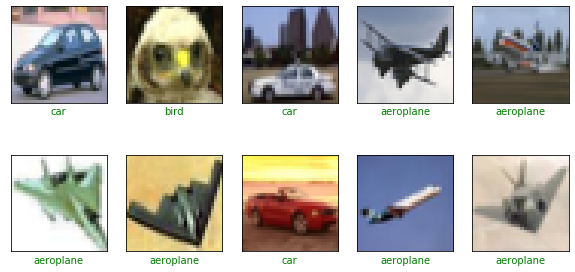

In [16]:
show_random_examples(x_test, y_test, y_test)

# Task 4: Create Model

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu')) #without padding the rows and cols will be reducted
        model.add(MaxPooling2D(pool_size=2)) #reduce the size of the input by half
        model.add(Dropout(0.5))
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    #adding convaluational layers
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam', metrics = ['accuracy']
    )
    
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)       


# Task 5: Train the Model

In [28]:
# h ->history -> what happen to validation, tranning loss and accuracy during the training process
h = model.fit(
    x_train/255., y_train,
    validation_data = (x_test/255., y_test),
    epochs = 10, batch_size = 128,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5',
        save_best_only=True, save_weights_only=False, 
        monitor='val_accuracy'
        )
    ]
)#save_weights_only = False -> indicates that we are not saving weight alone, but we need to save complete model

Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 136s 9ms/sample - loss: 0.2688 - accuracy: 0.8966 - val_loss: 0.2745 - val_accuracy: 0.8990
Epoch 2/10
15000/15000 [==============================] - 134s 9ms/sample - loss: 0.2629 - accuracy: 0.9003 - val_loss: 0.4101 - val_accuracy: 0.8550
Epoch 3/10
15000/15000 [==============================] - 134s 9ms/sample - loss: 0.2590 - accuracy: 0.8989 - val_loss: 0.2547 - val_accuracy: 0.9040
Epoch 4/10
15000/15000 [==============================] - 134s 9ms/sample - loss: 0.2472 - accuracy: 0.9049 - val_loss: 0.4340 - val_accuracy: 0.8507
Epoch 5/10
15000/15000 [==============================] - 135s 9ms/sample - loss: 0.2375 - accuracy: 0.9069 - val_loss: 0.2788 - val_accuracy: 0.8863
Epoch 6/10
15000/15000 [==============================] - 134s 9ms/sample - loss: 0.2276 - accuracy: 0.9127 - val_loss: 0.3009 - val_accuracy: 0.8870


In [25]:
'''patience = 3, in this case, if the val_accuracy not improving
for 3 epochs, then the training will stop
'''

'patience = 3, in this case, if the val_accuracy not improving\nfor 3 epochs, then the training will stop\n'

# Task 6: Final Predictions

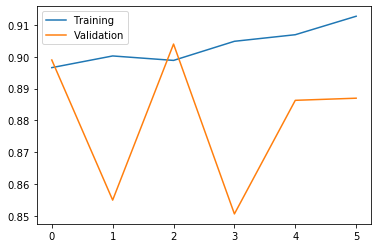

In [29]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Validation')
plt.legend()
plt.show()

In [30]:
model = tf.keras.models.load_model('models/model_0.904.h5')

In [31]:
preds = model.predict(x_test/255.)

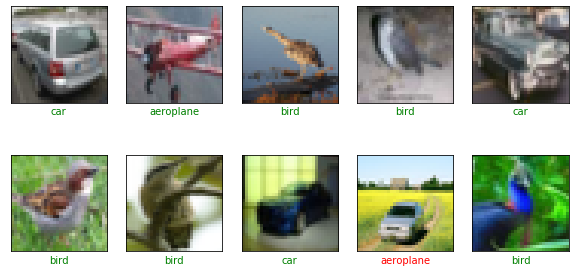

In [34]:
show_random_examples(x_test, y_test, preds)